# PID controller with a brake

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
b1, b2, b3, b4, s0, s1, s2 = ?

while(t < T):

    # decides whether brake is needed
    if b1*d+b2>0 and b3*d+4>0 {
        brakev = -1
    } else {
        brakev = 1
    }

    d = ang - 3.14
    torq = s0 *  d + s1 * v + s2 * id + brakev + gauss(0, 0.5);
    id = 0.9*id + d
    oldv= v 

    v = v + 0.01*torq + gauss(0, 0.5)
    ang = ang + 0.05*(v + oldv) + gauss(0, 0.1)

    if ang > 6.28 {
        ang = ang - 6.28
    } elif ang < 0 {
        ang = and + 6.28
    }  
```

In [8]:
from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time

torch.set_default_dtype(torch.float64)

### Original Model

In [9]:
target = 3.14
dt = 0.1
inertia = 10
decay = 0.9


def orig_model(T=50, init_ang = 0.5, b1=-1, b2=-2, b3=1, b4=-6, s0=1, s1=1, s2=1):
    
    traj = torch.zeros(T)

    smoothing = distributions.Normal(torch.tensor(0.), torch.tensor(0.05))
    noise = distributions.Normal(torch.tensor(0.), torch.tensor(0.25))
    noise_ang = distributions.Normal(torch.tensor(0.), torch.tensor(0.25))

    v = 0 #+ smoothing.rsample()
    ang = init_ang #+ smoothing.rsample()
    id = 0 #+ smoothing.rsample()
    old_v = 0 #+ smoothing.rsample()

    for i in range(0,T):

        traj[i] = ang #+ smoothing.rsample()
        
        d = target - ang #+smoothing.rsample()
        torq = s0*d + s1*v + s2*id #+ smoothing.rsample() # + brakev
        id = decay*id + d*dt
        oldv = v #+ smoothing.rsample()
        
        v = v + (dt/inertia)*torq + noise.rsample()
        ang = ang + (dt/2)*(v+oldv) + noise_ang.rsample()
        
        #if b1*d+b2>0 and b2*d+b4>0:
        #    brakev = -1
        #else:
        # brakev = 1        
        
        #if ang > 6.28:
        #    ang = ang - 6.28
        #elif ang < 0:
        #    ang = ang + 6.28

    traj[T-1] = ang #+ smoothing.rsample()

    return traj        

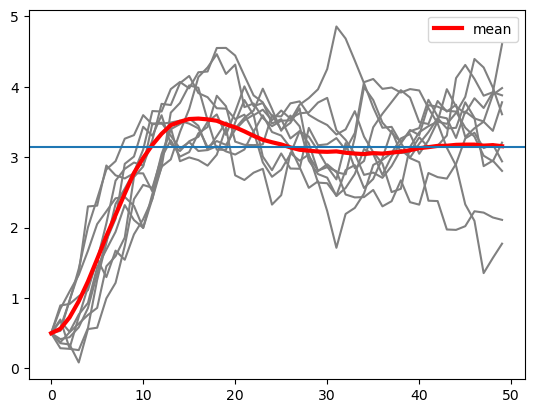

In [10]:
# generation of a set of trajectories

import matplotlib.pyplot as plt

T = 50
s0 = 46
s1 = -23
s2 = 0
init_ang = 0.5

traj_set = []
for _ in range(500):
    traj_set.append(orig_model(T, init_ang, s0=s0, s1=s1, s2=s2))
traj_set = torch.vstack(traj_set)

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(T), traj_set[i], color='grey')

plt.plot(range(T), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.axhline(y=target)
plt.legend()

### SOGA program

In [11]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/PIDNoSmooth.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

pars = {'s0':46., 's1':-23., 's2':0.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)

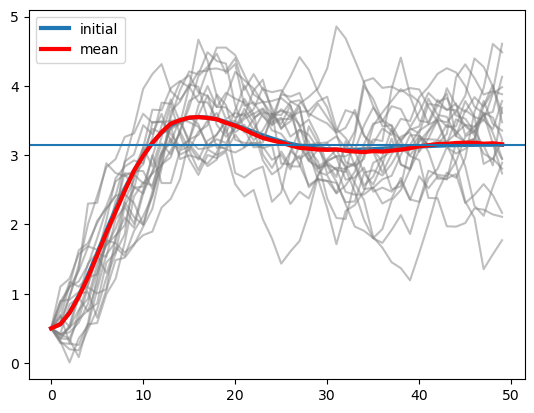

In [12]:
import matplotlib.pyplot as plt

T = 50
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='initial')

# plotting the first ten trajectories
for i in range(20):
    plt.plot(range(T), traj_set[i], color='grey', alpha=0.5)

plt.plot(range(T), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.axhline(y=target)

plt.legend()

In [13]:
def neg_log_likelihood(traj_set, dist):
    idx = list(range(1,20))
    log_likelihood = torch.log(dist.gm.marg_pdf(traj_set[i, 1:], idx))
    return - torch.sum(log_likelihood)

def L2_distance(traj_set, dist):
    idx = list(range(1,T))
    output_traj = dist.gm.mean()[idx]
    return torch.sum(torch.pow(traj_set[:, idx] - output_traj,2))

def signal_error(dist, target=3.14, eps=0.1, T=50):
    idx = list(range(1,T))
    target_signal = target*torch.ones(len(idx))
    return torch.sum(torch.pow(dist.gm.mean()[idx] - target_signal, 2))

signal_error(output_dist)

tensor(27.2889, grad_fn=<SumBackward0>)

In [14]:
# Define the optimizer with init_mean as the parameter

#torch.autograd.set_detect_anomaly(True)

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.1)

start = time()

for i in range(500):
    
    optimizer.zero_grad()  # Reset gradients
    
    #with torch.autograd.set_detect_anomaly(True):
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = signal_error(current_dist)
        
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item()) + ' '
        out = out + f" loss: {loss.item()}"
        print(out)

end = time()

print('Optimization performed in ' + str(end-start) + ' seconds.')

s0: 46.09999999704237 s1: -23.09999998199425 s2: -0.09999998597804378  loss: 27.288877642602564
s0: 51.006473662958484 s1: -23.74891417241443 s2: -4.75334122601432  loss: 25.45719445486158
s0: 55.563373599627084 s1: -23.856654382128774 s2: -8.871706225376444  loss: 24.04720217351379
s0: 59.834283487259036 s1: -24.1669426067802 s2: -12.326892516388902  loss: 22.916529435318388
s0: 63.8889167554159 s1: -24.61987217032934 s2: -15.169640111337767  loss: 21.97692443004748
s0: 67.77267047919523 s1: -25.177434744249577 s2: -17.489023669653896  loss: 21.173347166408053
s0: 71.51593697475325 s1: -25.8065014374604 s2: -19.384226810549375  loss: 20.47073788063581
s0: 75.14008302853681 s1: -26.479921370647375 s2: -20.948294013027784  loss: 19.846082341157995
s0: 78.66100033251969 s1: -27.177236024577894 s2: -22.259732224568207  loss: 19.28367536322642
s0: 82.09114038744144 s1: -27.884062713348328 s2: -23.380436440563923  loss: 18.772328560212532
Optimization performed in 482.98506712913513 seconds

In [15]:
params_dict

{'s0': tensor(85.3744, requires_grad=True),
 's1': tensor(-28.5767, requires_grad=True),
 's2': tensor(-24.3389, requires_grad=True)}

In [16]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/PID.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)

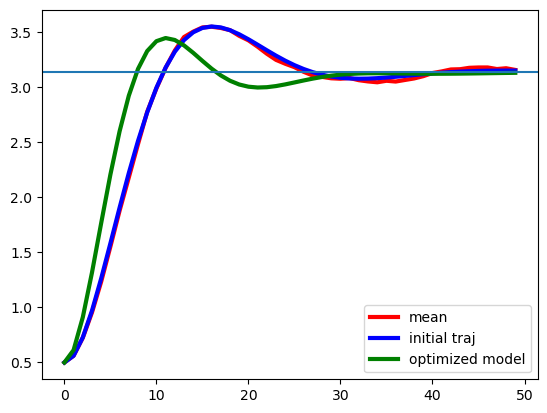

In [17]:
import matplotlib.pyplot as plt

# plotting the first ten trajectories
#for i in range(20):
#    plt.plot(range(T), traj_set[i], color='grey')

plt.plot(range(T), torch.mean(traj_set, 0), lw=3, color='red', label='mean')

plt.plot(range(T), y_init, lw=3, color='blue', label='initial traj')

plt.plot(range(T), output_dist.gm.mean()[:T].detach(), lw=3, color='green', label='optimized model')

plt.axhline(y=target)


plt.legend()